# Download dataset

In [ ]:
import os
import zipfile
import requests
import pandas as pd
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm

# Step 1: Scarica e decomprimi il dataset con barra di avanzamento
def download_and_unzip(url, extract_to='.'):
    local_zip = 'ODAQ_dataset.zip'
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kibibyte

    with open(local_zip, 'wb') as f, tqdm(
        desc="Scaricamento ODAQ",
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            f.write(data)
            bar.update(len(data))

    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(local_zip)

# Step 2: Dataset PyTorch
class ODAQDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, target_sample_rate=44100, n_mels=64):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.target_sample_rate = target_sample_rate
        self.mel_spectrogram = MelSpectrogram(
            sample_rate=self.target_sample_rate,
            n_mels=n_mels,
            n_fft=1024,
            hop_length=512
        )
        self.amplitude_to_db = AmplitudeToDB()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.annotations.iloc[idx, 0])
        waveform, sample_rate = torchaudio.load(audio_path)
        if sample_rate != self.target_sample_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)(waveform)
        mel_spec = self.mel_spectrogram(waveform)
        mel_spec_db = self.amplitude_to_db(mel_spec)
        score = torch.tensor(self.annotations.iloc[idx, 1], dtype=torch.float32)
        return mel_spec_db, score
# Step 3: Esegui tutto
def prepare_dataset():
    # dataset_url = 'https://zenodo.org/records/10405774/files/ODAQ.zip'
    # download_and_unzip(dataset_url, 'ODAQ_dataset')
    annotations_file = 'ODAQ_dataset/ODAQ/ODAQ_listening_test/ODAQ_results.csv'
    audio_dir = 'ODAQ_dataset/ODAQ/ODAQ_listening_test'
    dataset = ODAQDataset(annotations_file, audio_dir)
    return dataset

# Esempio di utilizzo
if __name__ == "__main__":
    dataset = prepare_dataset()
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    for mel_specs, scores in dataloader:
        print(mel_specs.shape, scores.shape)
        break


Scaricamento ODAQ: 100%|██████████| 0.98G/0.98G [02:30<00:00, 6.98MiB/s]    


FileNotFoundError: [Errno 2] No such file or directory: 'ODAQ_dataset/ODAQ_results.csv'

# Dataset build

In [1]:
import pandas as pd
import os

csv_path = "ODAQ_dataset/ODAQ_results.csv"

# Carica il file Excel
df = pd.read_csv(csv_path)

# Calcola la media dei punteggi per ciascun 'item'
mean_scores = df.groupby(['item', 'process'])['score'].mean().reset_index()

# Rinomina le colonne per chiarezza
mean_scores.columns = ['item', 'process', 'mean_score']
# Save il DataFrame in un file CSV
mean_scores.to_csv("ODAQ_dataset/mean_scores_long.csv", index=False)


In [37]:
import librosa
import torch

class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_length=2400):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform or torchaudio.transforms.MelSpectrogram()
        self.target_length = target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        item = row['item']
        process = row['process']
        score = torch.tensor(row['mean_score'], dtype=torch.float32)

        wav_path = os.path.join(self.root_dir, item, f"{process}.wav")

        # Usa librosa per compatibilità
        waveform_np, sr = librosa.load(wav_path, sr=None) 
        waveform = torch.tensor(waveform_np)

        spectrogram = self.transform(waveform)  # [n_mels, time]
        spectrogram = torch.log1p(spectrogram)
        spectrogram = (spectrogram - spectrogram.mean()) / (spectrogram.std() + 1e-6)

        # Taglia o riempi con zeri per lunghezza fissa
        if spectrogram.shape[1] < self.target_length:
            pad_size = self.target_length - spectrogram.shape[1]
            spectrogram = torch.nn.functional.pad(spectrogram, (0, pad_size))
        else:
            spectrogram = spectrogram[:, :self.target_length]
        
        spectrogram = spectrogram.unsqueeze(0)  # [1, n_mels, time]


        return {
            'spectrogram': spectrogram,
            'score': score
        }


In [38]:
from torch.utils.data import random_split, DataLoader

csv_path = "ODAQ_dataset/mean_scores_long.csv"

# Dataset intero
full_dataset = SpectrogramDataset(csv_path, root_dir="ODAQ_dataset")

# Lunghezze per la divisione
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Assicura somma esatta

# Suddivisione casuale (usa seed per ripetibilità)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)  # seed riproducibile
)

# DataLoader per ciascun set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


c:\Users\radul\anaconda3\envs\audio_restore_project\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [39]:
# get one dataloader element
print("Train loader example:")
for batch in train_loader:
    spectrogram = batch['spectrogram']
    score = batch['score']
    print(f"Spectrogram shape: {spectrogram.shape}, Score shape: {score.shape}")
    break

Train loader example:
Spectrogram shape: torch.Size([32, 1, 128, 2400]), Score shape: torch.Size([32])


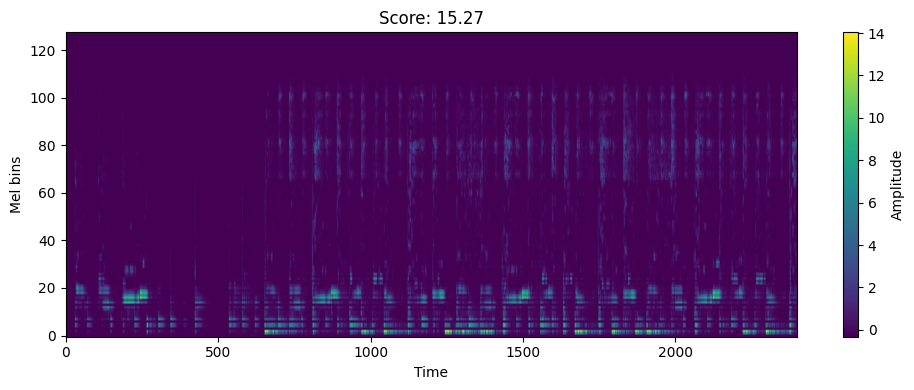

In [40]:
import matplotlib.pyplot as plt

# Mostra il primo spettrogramma del batch
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram[0].squeeze(0).numpy(), aspect='auto', origin='lower')
plt.title(f"Score: {score[0].item():.2f}")
plt.colorbar(label='Amplitude')
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.tight_layout()
plt.show()


# MODEL

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class AudioQualityCNN(nn.Module):
    def __init__(self):
        super(AudioQualityCNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # [16, 64, 1200]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # [32, 32, 600]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))   # [64, 16, 300]
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),                      # [64 * 16 * 300] = 307200
            nn.Linear(64 * 16 * 300, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)                  # Output: qualità
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x.squeeze(1)  # Output shape: [batch_size]


# TRAIN

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

# Assumiamo che tu abbia già:
# - il modello AudioQualityCNN
# - train_loader, val_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioQualityCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()  # oppure L1Loss per MAE

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['spectrogram'].to(device)
            targets = batch['score'].to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            total_mae += torch.sum(torch.abs(outputs - targets)).item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    avg_mae = total_mae / total_samples
    return avg_loss, avg_mae


def train(model, train_loader, val_loader, epochs=20):
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs = batch['spectrogram'].to(device)
            targets = batch['score'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        val_loss, val_mae = evaluate(model, val_loader)

        print(f"\nEpoch {epoch+1}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val MAE:    {val_mae:.4f}")

        # Salva il modello se migliora
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "model/best_audio_quality_model.pt")
            print("✅ Model saved")



In [43]:
train(model, train_loader, val_loader, epochs=30)


Epoch 1/30: 100%|██████████| 6/6 [00:25<00:00,  4.21s/it]



Epoch 1:
  Train Loss: 1548.6933
  Val Loss:   2659.7244
  Val MAE:    41.5351
✅ Model saved


Epoch 2/30: 100%|██████████| 6/6 [00:22<00:00,  3.67s/it]



Epoch 2:
  Train Loss: 768.6587
  Val Loss:   2178.9418
  Val MAE:    35.5338
✅ Model saved


Epoch 3/30: 100%|██████████| 6/6 [00:21<00:00,  3.51s/it]



Epoch 3:
  Train Loss: 913.9618
  Val Loss:   1401.6370
  Val MAE:    28.9786
✅ Model saved


Epoch 4/30: 100%|██████████| 6/6 [00:20<00:00,  3.43s/it]



Epoch 4:
  Train Loss: 912.0234
  Val Loss:   963.7572
  Val MAE:    25.4115
✅ Model saved


Epoch 5/30: 100%|██████████| 6/6 [00:21<00:00,  3.57s/it]



Epoch 5:
  Train Loss: 637.8955
  Val Loss:   1166.1809
  Val MAE:    26.3247


Epoch 6/30: 100%|██████████| 6/6 [00:19<00:00,  3.27s/it]



Epoch 6:
  Train Loss: 669.5159
  Val Loss:   832.8523
  Val MAE:    25.2620
✅ Model saved


Epoch 7/30: 100%|██████████| 6/6 [00:21<00:00,  3.57s/it]



Epoch 7:
  Train Loss: 647.3560
  Val Loss:   842.6619
  Val MAE:    24.9323


Epoch 8/30: 100%|██████████| 6/6 [00:21<00:00,  3.52s/it]



Epoch 8:
  Train Loss: 573.5691
  Val Loss:   862.7028
  Val MAE:    25.0775


Epoch 9/30: 100%|██████████| 6/6 [00:20<00:00,  3.38s/it]



Epoch 9:
  Train Loss: 569.7601
  Val Loss:   866.6029
  Val MAE:    25.1749


Epoch 10/30: 100%|██████████| 6/6 [00:19<00:00,  3.29s/it]



Epoch 10:
  Train Loss: 580.0040
  Val Loss:   864.5006
  Val MAE:    24.8821


Epoch 11/30: 100%|██████████| 6/6 [00:19<00:00,  3.31s/it]



Epoch 11:
  Train Loss: 604.4026
  Val Loss:   833.1331
  Val MAE:    25.6378


Epoch 12/30: 100%|██████████| 6/6 [00:19<00:00,  3.25s/it]



Epoch 12:
  Train Loss: 575.5513
  Val Loss:   810.7679
  Val MAE:    24.4698
✅ Model saved


Epoch 13/30: 100%|██████████| 6/6 [00:19<00:00,  3.31s/it]



Epoch 13:
  Train Loss: 539.0085
  Val Loss:   804.4501
  Val MAE:    24.4413
✅ Model saved


Epoch 14/30: 100%|██████████| 6/6 [00:19<00:00,  3.27s/it]



Epoch 14:
  Train Loss: 491.8804
  Val Loss:   813.9501
  Val MAE:    24.2185


Epoch 15/30: 100%|██████████| 6/6 [00:19<00:00,  3.26s/it]



Epoch 15:
  Train Loss: 473.4998
  Val Loss:   795.5249
  Val MAE:    24.3470
✅ Model saved


Epoch 16/30: 100%|██████████| 6/6 [00:19<00:00,  3.26s/it]



Epoch 16:
  Train Loss: 485.4438
  Val Loss:   781.8091
  Val MAE:    23.9781
✅ Model saved


Epoch 17/30: 100%|██████████| 6/6 [00:19<00:00,  3.25s/it]



Epoch 17:
  Train Loss: 472.8638
  Val Loss:   784.9079
  Val MAE:    23.6886


Epoch 18/30: 100%|██████████| 6/6 [00:19<00:00,  3.24s/it]



Epoch 18:
  Train Loss: 454.5301
  Val Loss:   775.9575
  Val MAE:    23.8531
✅ Model saved


Epoch 19/30: 100%|██████████| 6/6 [00:19<00:00,  3.24s/it]



Epoch 19:
  Train Loss: 474.1484
  Val Loss:   771.0586
  Val MAE:    24.1634
✅ Model saved


Epoch 20/30: 100%|██████████| 6/6 [00:19<00:00,  3.32s/it]



Epoch 20:
  Train Loss: 457.8509
  Val Loss:   763.3889
  Val MAE:    23.5833
✅ Model saved


Epoch 21/30: 100%|██████████| 6/6 [00:19<00:00,  3.27s/it]



Epoch 21:
  Train Loss: 477.2925
  Val Loss:   760.5282
  Val MAE:    23.1621
✅ Model saved


Epoch 22/30: 100%|██████████| 6/6 [00:19<00:00,  3.24s/it]



Epoch 22:
  Train Loss: 447.4192
  Val Loss:   751.1496
  Val MAE:    23.2005
✅ Model saved


Epoch 23/30: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]



Epoch 23:
  Train Loss: 436.7714
  Val Loss:   734.4380
  Val MAE:    23.0404
✅ Model saved


Epoch 24/30: 100%|██████████| 6/6 [00:19<00:00,  3.29s/it]



Epoch 24:
  Train Loss: 436.4796
  Val Loss:   738.1391
  Val MAE:    23.5114


Epoch 25/30: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]



Epoch 25:
  Train Loss: 394.5353
  Val Loss:   769.6513
  Val MAE:    22.8575


Epoch 26/30: 100%|██████████| 6/6 [00:19<00:00,  3.31s/it]



Epoch 26:
  Train Loss: 428.9077
  Val Loss:   738.8957
  Val MAE:    22.7155


Epoch 27/30: 100%|██████████| 6/6 [00:19<00:00,  3.29s/it]



Epoch 27:
  Train Loss: 434.7262
  Val Loss:   721.6955
  Val MAE:    22.1434
✅ Model saved


Epoch 28/30: 100%|██████████| 6/6 [00:19<00:00,  3.28s/it]



Epoch 28:
  Train Loss: 370.8096
  Val Loss:   675.9542
  Val MAE:    22.1401
✅ Model saved


Epoch 29/30: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]



Epoch 29:
  Train Loss: 403.7630
  Val Loss:   659.8076
  Val MAE:    21.7434
✅ Model saved


Epoch 30/30: 100%|██████████| 6/6 [00:19<00:00,  3.29s/it]



Epoch 30:
  Train Loss: 357.1988
  Val Loss:   654.2838
  Val MAE:    21.8951
✅ Model saved
